# Fine Tuning DistilBERT

In [ ]:
pip install "transformers[torch]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 8.0 MB/s eta 0:00:00


In [ ]:
# Importing the libraries needed
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer

In [ ]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
#device = 'cpu'

### Importing the data



In [ ]:
# Import the csv into pandas dataframe and add the headers
df_train = pd.read_excel('/content/Train_set.xlsx')
df_val = pd.read_excel('/content/Validation_set.xlsx')
df_test = pd.read_excel('/content/Test_set.xlsx')


# df.head()
# # Removing unwanted columns and only leaving title of news and the category which will be the target
df_train = df_train[['Categorización','Comentarios_limpios']]
df_val = df_val[['Categorización','Comentarios_limpios']]
df_test = df_test[['Categorización','Comentarios_limpios']]
# df.head()

# # Converting the codes to appropriate categories using a dictionary
my_dict = {
    'MALO':'negative',
    'MIXTO':'neutral',
    'BUENO':'positive'
}

def update_cat(x):
    return my_dict[x]

df_train['CATEGORY'] = df_train['Categorización'].apply(lambda x: update_cat(x))
df_val['CATEGORY'] = df_val['Categorización'].apply(lambda x: update_cat(x))
df_test['CATEGORY'] = df_test['Categorización'].apply(lambda x: update_cat(x))

encode_dict = {}

def encode_cat(x):
    if x not in encode_dict.keys():
        encode_dict[x]=len(encode_dict)
    return encode_dict[x]

df_train['ENCODE_CAT'] = df_train['CATEGORY'].apply(lambda x: encode_cat(x))
df_train = df_train[["Comentarios_limpios", "CATEGORY", "ENCODE_CAT"]]

df_val['ENCODE_CAT'] = df_val['CATEGORY'].apply(lambda x: encode_cat(x))
df_val = df_val[["Comentarios_limpios", "CATEGORY", "ENCODE_CAT"]]

df_test['ENCODE_CAT'] = df_test['CATEGORY'].apply(lambda x: encode_cat(x))
df_test = df_test[["Comentarios_limpios", "CATEGORY", "ENCODE_CAT"]]

### Preparing the Dataset and Dataloader



In [ ]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
TEST_BATCH_SIZE = 2
EPOCHS = 4
LEARNING_RATE = 2e-05
tokenizer = DistilBertTokenizer.from_pretrained('lxyuan/distilbert-base-multilingual-cased-sentiments-student')

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

In [ ]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        title = str(self.data.Comentarios_limpios[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.ENCODE_CAT[index], dtype=torch.long)
        }

    def __len__(self):
        return self.len

In [ ]:
# Creating the dataset and dataloader for the neural network
train_dataset = df_train.reset_index(drop=True)
validation_dataset=df_val.reset_index(drop=True)
test_dataset = df_test.reset_index(drop=True)


print("TRAIN Dataset: {}".format(train_dataset.shape))
print("VALIDATION Dataset: {}".format(validation_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
validation_set = Triage(validation_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

TRAIN Dataset: (3153, 3)
VALIDATION Dataset: (1050, 3)
TEST Dataset: (1053, 3)


In [ ]:
train_dataset.head()

,Comentarios_limpios,CATEGORY,ENCODE_CAT
0,pasar clase necesita ademas foro escribir refe...,neutral,0
1,gustaria cuestionarios tipo examen examenes pr...,neutral,0
2,incluir actividades grupales interactivas proc...,neutral,0
3,considero falto ayuda parte poder enterder bie...,neutral,0
4,juan desorganizado respecto imparte clases hab...,neutral,0


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

validation_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **validation_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
print(testing_loader)

### Creating the Neural Network for Fine Tuning



In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.

class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 3)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
model = DistillBERTClass()
model.to(device)

config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(

In [ ]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

### Fine Tuning the Model

In [ ]:
# Function to calcuate the accuracy of the model

def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model
lista_acc_train = []
lista_loss_train = []
best_accuracy_train = 0

def train(epoch):

    global best_accuracy_train, predictions_final_train, targets_list_final_train
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    predictions_train = []
    targets_list_train = []
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
        targets_list_train.extend(targets.cpu().numpy())

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%1000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        predictions_train.extend(predicted.cpu().numpy())

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")
    lista_acc_train.append(epoch_accu)
    lista_loss_train.append(epoch_loss)

    if best_accuracy_train < epoch_accu:
      predictions_final_train = predictions_train
      targets_list_final_train = targets_list_train

    best_accuracy_train = epoch_accu


    return lista_acc_train, lista_loss_train, predictions_final_train, targets_list_final_train

### Validating the Model


In [ ]:
best_accuracy = 0
predictions_final_valid = []  # Initialize predictions_final_valid outside the loop
targets_list_final_valid = []
lista_loss_valid = []
lista_acc_valid = []

def valid(model, testing_loader):
    global best_accuracy, predictions_final_valid, targets_list_final_valid
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0
    tr_loss = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    lista_1 = []
    lista_2 = []
    predictions = []
    targets_list = []
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            predicted_classes = torch.argmax(outputs, dim=1)
            lista_1.append(predicted_classes[0])
            lista_2.append(predicted_classes[1])
            #print("Predicted Labels:", predicted_classes)
            targets_list.extend(targets.cpu().numpy())
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accu(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    values_1 = [tensor.item() for tensor in lista_1]
    values_2 = [tensor.item() for tensor in lista_2]
    lista = []

    lista_acc_valid.append(epoch_accu)
    lista_loss_valid.append(epoch_loss)

    for i in range(len(values_1)):
      predictions.append(values_1[i])
      predictions.append(values_2[i])


    if best_accuracy < epoch_accu:

      predictions_final_valid = predictions
      targets_list_final_valid = targets_list

    best_accuracy = epoch_accu

    return epoch_accu, predictions_final_valid, targets_list_final_valid, lista_acc_valid, lista_loss_valid


In [ ]:
lista_acc_train = []
lista_loss_train = []
lista_loss_valid = []
lista_acc_valid = []
best_accuracy_train = 0
best_accuracy = 0
predictions_final_valid = []  # Initialize predictions_final_valid outside the loop
targets_list_final_valid = []


for epoch in range(EPOCHS):
    y_train_acc, y_train_loss, preds_train, targets_train = train(epoch)
    acc, preds_validation, targ_list_validation, y_valid_acc, y_valid_loss = valid(model, validation_loader)
    print("Accuracy on test data = %0.2f%%" % acc)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 1.075210690498352
Training Accuracy per 5000 steps: 50.0
The Total Accuracy for Epoch 0: 67.0789724072312
Training Loss Epoch: 0.7200311978355862
Training Accuracy Epoch: 67.0789724072312
Validation Loss per 100 steps: 0.21775570511817932
Validation Accuracy per 100 steps: 100.0
Validation Loss Epoch: 0.5795138241421609
Validation Accuracy Epoch: 74.95238095238095
Accuracy on test data = 74.95%
Training Loss per 5000 steps: 0.39483642578125
Training Accuracy per 5000 steps: 75.0
The Total Accuracy for Epoch 1: 80.30447193149382
Training Loss Epoch: 0.4799206797057156
Training Accuracy Epoch: 80.30447193149382
Validation Loss per 100 steps: 0.8976958990097046
Validation Accuracy per 100 steps: 50.0
Validation Loss Epoch: 0.5170164911519913
Validation Accuracy Epoch: 78.95238095238095
Accuracy on test data = 78.95%
Training Loss per 5000 steps: 0.3159986734390259
Training Accuracy per 5000 steps: 100.0
The Total Accuracy for Epoch 2: 86.67935299714557
Traini

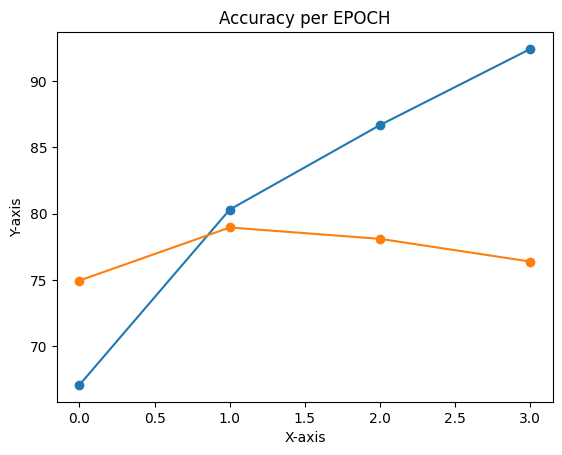

In [ ]:
import matplotlib.pyplot as plt

# Sample data

x_train = []

for i in range(EPOCHS):
  x_train.append(i)

# Create the line plot
plt.plot(x_train, y_train_acc, marker='o')
plt.plot(x_train, y_valid_acc, marker='o')

# Add title and labels
plt.title('Accuracy per EPOCH')
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')

# Display the plot
plt.show()

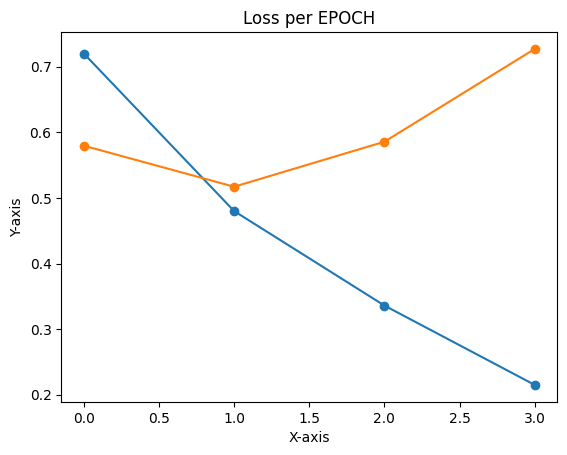

In [ ]:
x_train = []

for i in range(EPOCHS):
  x_train.append(i)

# Create the line plot
plt.plot(x_train, y_train_loss, marker='o')
plt.plot(x_train, y_valid_loss, marker='o')

# Add title and labels
plt.title('Loss per EPOCH')
plt.xlabel('EPOCH')
plt.ylabel('Loss')

# Display the plot
plt.show()

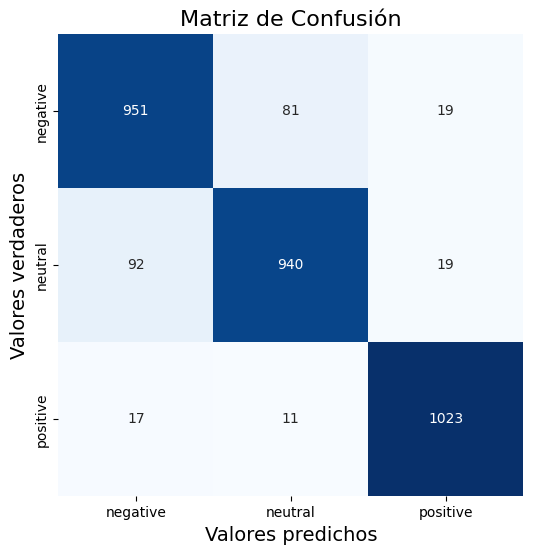

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
predicted_labels = [label_mapping[val] for val in preds_train]
labels_graph = ["negative", "neutral", "positive"]


labels = [label_mapping[val] for val in targets_train]
cm = confusion_matrix(labels, predicted_labels, labels = labels_graph)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels_graph,
                yticklabels=labels_graph)
plt.xlabel('Valores predichos', fontsize=14)
plt.ylabel('Valores verdaderos', fontsize=14)
plt.title('Matriz de Confusión', fontsize=16)
plt.show()

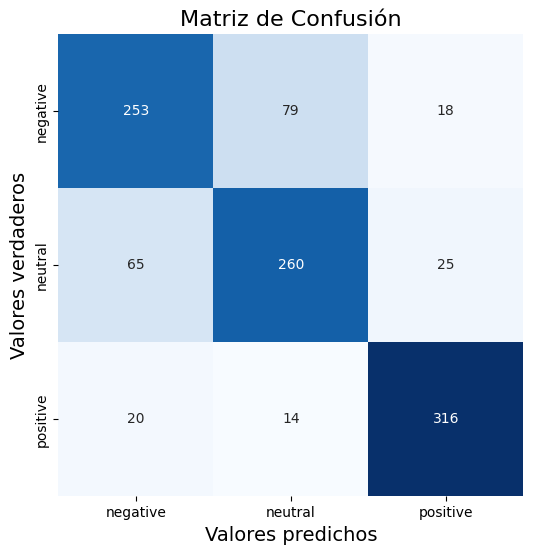

In [ ]:
label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
predicted_labels = [label_mapping[val] for val in preds_validation]
labels_graph = ["negative", "neutral", "positive"]


labels = [label_mapping[val] for val in targ_list_validation]
cm = confusion_matrix(labels, predicted_labels, labels = labels_graph)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels_graph,
                yticklabels=labels_graph)
plt.xlabel('Valores predichos', fontsize=14)
plt.ylabel('Valores verdaderos', fontsize=14)
plt.title('Matriz de Confusión', fontsize=16)
plt.show()

### Testing the model

In [ ]:
lista_loss_valid = []
lista_acc_valid = []
best_accuracy = 0
predictions_final_valid = []  # Initialize predictions_final_valid outside the loop
targets_list_final_valid = []

acc, preds_test, targ_list_test, y_test_acc, y_test_loss = valid(model, testing_loader)
print(acc)

Validation Loss per 100 steps: 0.06435173749923706
Validation Accuracy per 100 steps: 100.0
Validation Loss Epoch: 0.7433647429278688
Validation Accuracy Epoch: 76.54320987654322
76.54320987654322


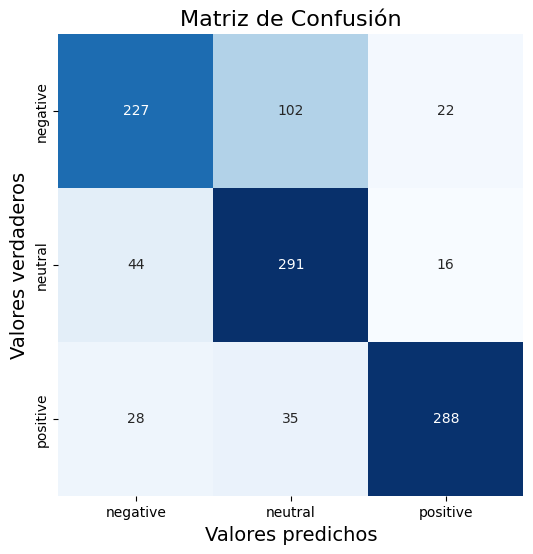

In [ ]:
label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
predicted_labels = [label_mapping[val] for val in preds_test]
labels_graph = ["negative", "neutral", "positive"]


labels = [label_mapping[val] for val in targ_list_test]
cm = confusion_matrix(labels, predicted_labels, labels = labels_graph)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels_graph,
                yticklabels=labels_graph)
plt.xlabel('Valores predichos', fontsize=14)
plt.ylabel('Valores verdaderos', fontsize=14)
plt.title('Matriz de Confusión', fontsize=16)
plt.show()

### Saving the Trained Model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Saving the files for re-use

output_model_file = '/content/drive/MyDrive/Tesis/Jose/pytorch_distilbert_news.bin'
output_vocab_file = '/content/drive/MyDrive/Tesis/Jose/vocab_distilbert_news.bin'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')
print('This tutorial is completed')

All files saved
This tutorial is completed
